<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/solutions/advanced_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced models vs benchmarks for probabilistic forecasts
In this exercise we will train some advanced models on the M4 hourly dataset. The M4 hourly dataset has the following features:
* univariate time series
* scarce data (700 obs per series)
* different scales

We will
1. Create some benchmark forecasts 
2. Fit two neural forecasters 

Since we are in a data-scarce regime, both the benchmark model and the neural-based ones will be global models, that is, we will fit the same model on all the time series at once.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import warnings
warnings.filterwarnings("ignore")
from itertools import product

In [2]:
%%capture
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv

In [3]:
df_tr = pd.read_csv('M4-Hourly.csv')
df_te = pd.read_csv('M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

n_series = 8
uids = df_tr['unique_id'].unique()[:n_series]
df_tr = df_tr.query('unique_id in @uids')
df_te = df_te.query('unique_id in @uids')
df_hat = df_te.copy()
df_hat['y_test'] = 0
df_tr.head()


,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


## Benchmark forecaster
In the following we define a simple probabilistic benchmark model. The benchmark is the following:
* normalize the time series individually
* apply a moving average to detrend the series
* fit a linear model with a 2-days embedding
The probabilistic forecasts are obtained retrieving the bootstrapped errors on the training set

For each of the 8 selected series, we retrieve the NMAE:
$$nmae = \frac{\sum_{t=T}^{T+n_{sa}}\vert y_t-\hat{y}_t\vert}{\sum_{t=T}^{T+n_{sa}}\vert y_t \vert}$$

In [4]:

def get_hankel(df, embedding=3):
  return pd.concat([df.shift(-l) for l in range(embedding)], axis=1).iloc[:-embedding]

lagged_mav = lambda x, k: x.copy().rolling(k).mean()


class LinearForecaster:
  """
  A simple linear forecaster: retrieves the signal's Hankel matrix of
  the requested embedding and fits a linear regression on future values.
  """
  def __init__(self, steps_ahead=1, embedding=3):
    self.steps_ahead = steps_ahead
    self.embedding = embedding
    self.theta = None
    self.mean = None
    self.std = None

  def fit(self, y0):
    y = y0.copy()
    self.mean = np.array(y.mean())
    self.std = np.array(y.std())
    y_embedded = get_hankel(y, self.steps_ahead + self.embedding)
    x = y_embedded.iloc[:, :self.embedding].values/self.std-self.mean
    target = y_embedded.iloc[:, self.embedding:].values
    self.theta = np.linalg.pinv(x.T@x)@(x.T@target)
    return self

  def predict(self, df):
    x = df.iloc[-self.embedding:].values.reshape(1, -1)/self.std-self.mean
    preds = x @ self.theta
    return pd.DataFrame(preds.ravel(), index=df.iloc[-self.steps_ahead:].index + np.arange(self.steps_ahead), columns=['y_hat_lin'])


class LinearDetrendedForecaster:
  def __init__(self, steps_ahead=13, linear_embedding=3):
    self.steps_ahead = steps_ahead
    self.linear_embedding = linear_embedding
    self.rt_model = LinearForecaster(steps_ahead=steps_ahead, embedding=linear_embedding)

  def fit(self, df):
    # STL decomposition of the signal
    trend = lagged_mav(df, self.steps_ahead)
    filt = ~trend.isna()
    self.rt_model.fit((df-trend).loc[filt])
    return self

  def predict(self, df):
    trend = lagged_mav(df, self.steps_ahead)
    y_hat = self.rt_model.predict(df-trend) + trend.iloc[-1]
    y_hat.name = 'lin_detrended'
    return y_hat


In [5]:

# preprocessing
means, stds = {}, {}
df_tr_norm = df_tr.copy()
for uid in df_tr['unique_id'].unique():
    means[uid] = df_tr.query('unique_id == @uid')['y'].mean()
    stds[uid] = df_tr.query('unique_id == @uid')['y'].std()
    df_tr_norm.loc[df_tr['unique_id']==uid, 'y'] = (df_tr.query('unique_id == @uid')['y'] - means[uid])/stds[uid]


lm = LinearDetrendedForecaster(steps_ahead=48, linear_embedding=48).fit(df_tr_norm['y'])


In [6]:
# predict point forecasts
for uid in df_tr['unique_id'].unique():
    y_hat = lm.predict(df_tr_norm.loc[df_tr_norm['unique_id'] == uid, 'y']) * stds[uid] + means[uid]
    df_hat.loc[df_hat['unique_id'] == uid, 'y_test'] = y_hat.values

# retrieve errors on the training set
err_pdf = {}
q_vect = [0.05, 0.1, 0.9, 0.95]
for uid in df_tr['unique_id'].unique():
  errs_u = []
  for i in range(700-48*3):
    y_past = df_tr_norm.loc[df_tr_norm['unique_id'] == uid, 'y'].iloc[:48*2+i]
    y_te = df_tr_norm.loc[df_tr['unique_id'] == uid, 'y'].iloc[48*2+i:48*2+i + 48]
    y_hat = lm.predict(y_past)
    errs_u.append((y_te.values-y_hat.values.ravel()) * stds[uid])
  err_pdf[uid] = np.quantile(np.vstack(errs_u).T,q_vect, axis=1).T

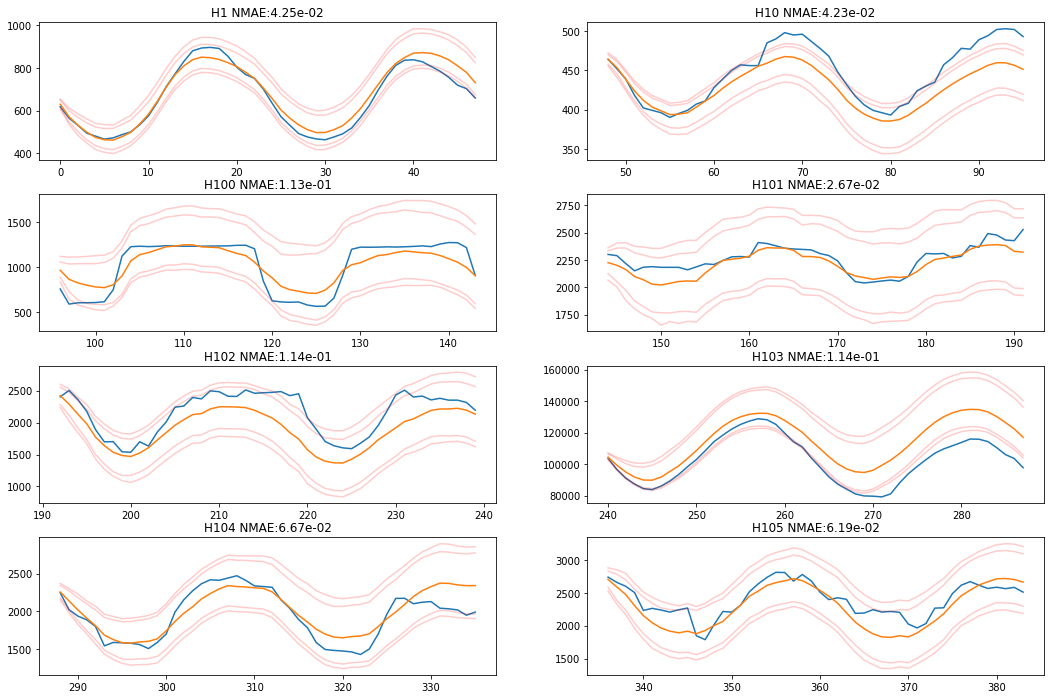

In [7]:
nmae = lambda x,y: np.mean(np.abs(x-y))/(np.mean(x)+1e-6)
# plot results
fig, ax = plt.subplots(4, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.25)
for uid, a in zip(df_tr['unique_id'].unique(), ax.ravel()):
    y_te = df_te.loc[df_hat['unique_id'] == uid, 'y_test']
    y_hat = df_hat.loc[df_hat['unique_id'] == uid, 'y_test']
    y_te.plot(ax=a)
    a.plot(y_hat.index, err_pdf[uid] + y_hat.values.reshape(-1, 1), color='red', alpha=0.2)
    y_hat.plot(ax=a)
    a.set_title('{} NMAE:{:0.2e}'.format(uid,nmae(y_te.values.ravel(), y_hat.values.ravel())))

## ❓ARIMA benchmark models
Create a benchmark forecaster using the [darts](https://unit8co.github.io/darts/#example-usage) library or the [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html) implementation. 
Train the model on `df_tr` and test and plot the forecasts on `df_te` along with the NMAE score.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecast

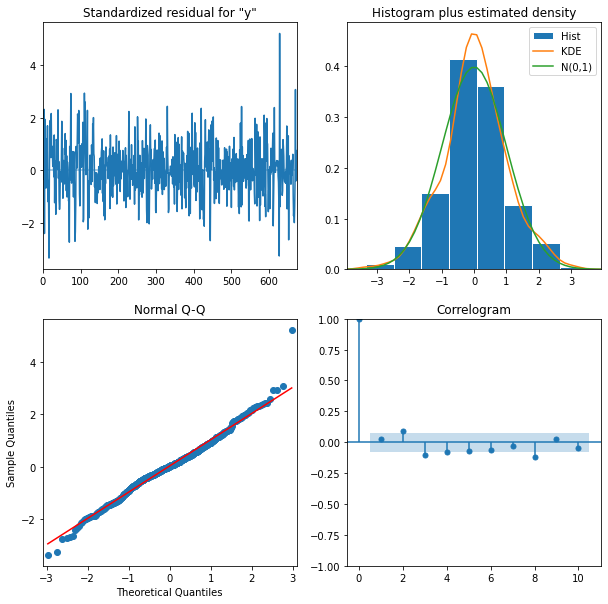

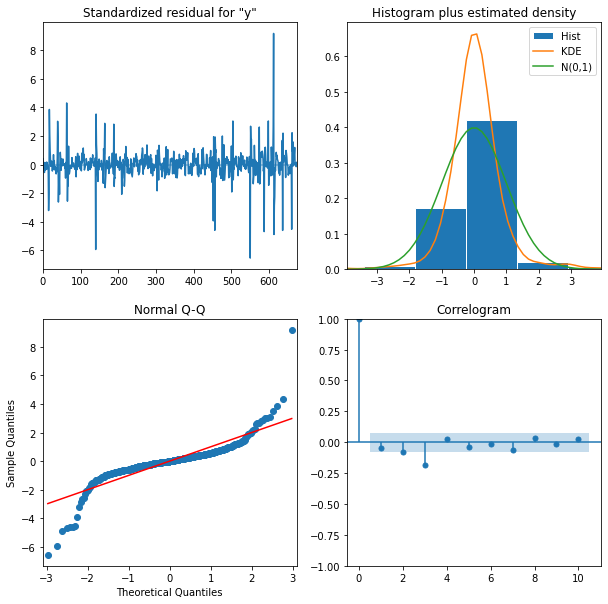

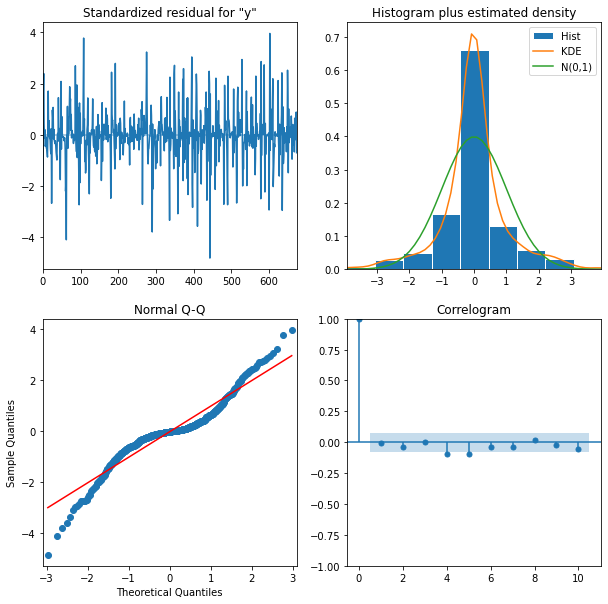

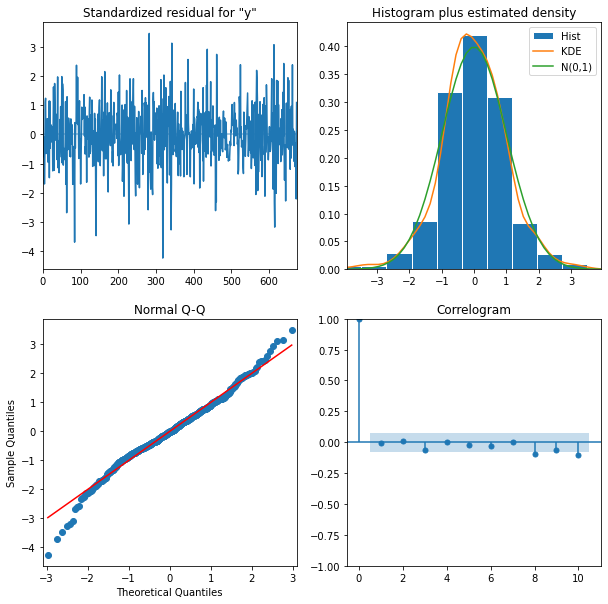

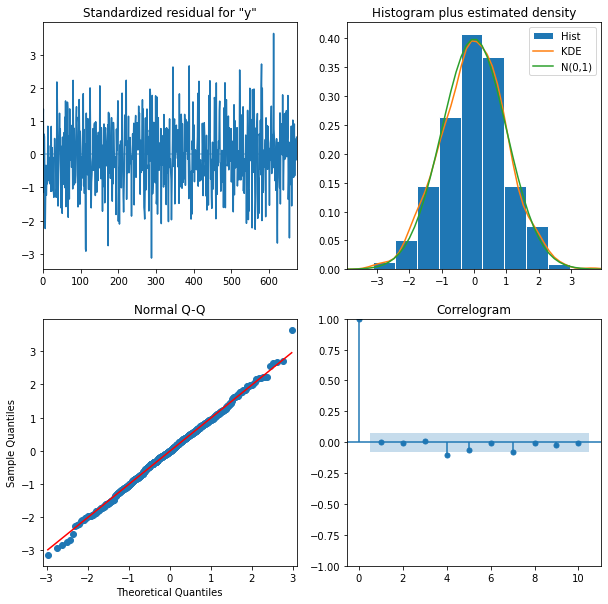

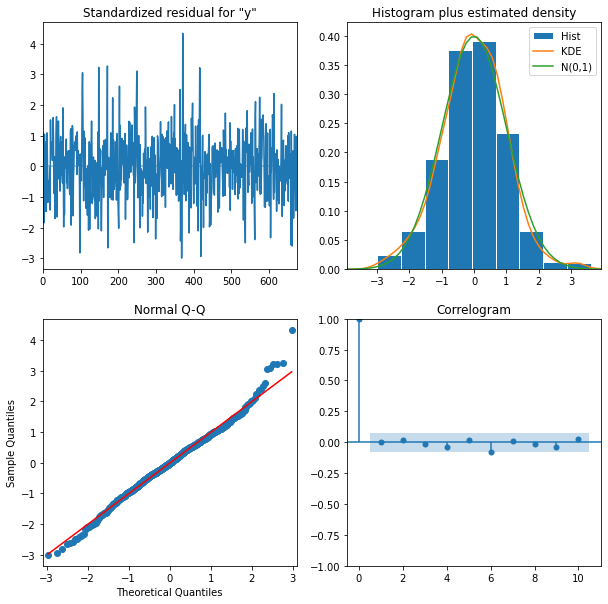

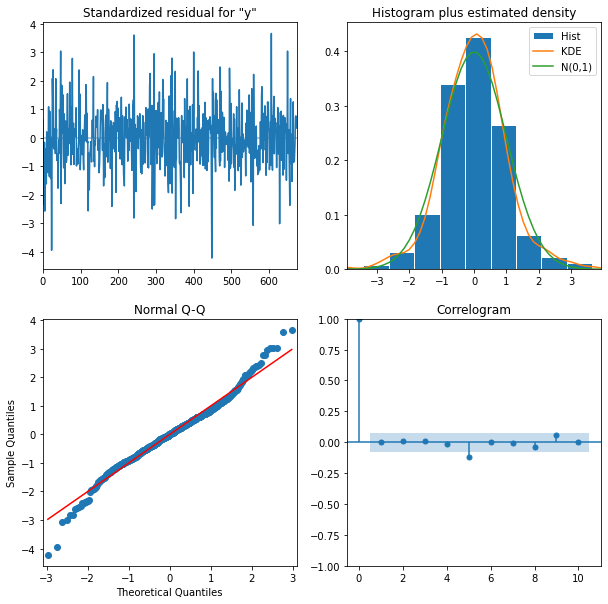

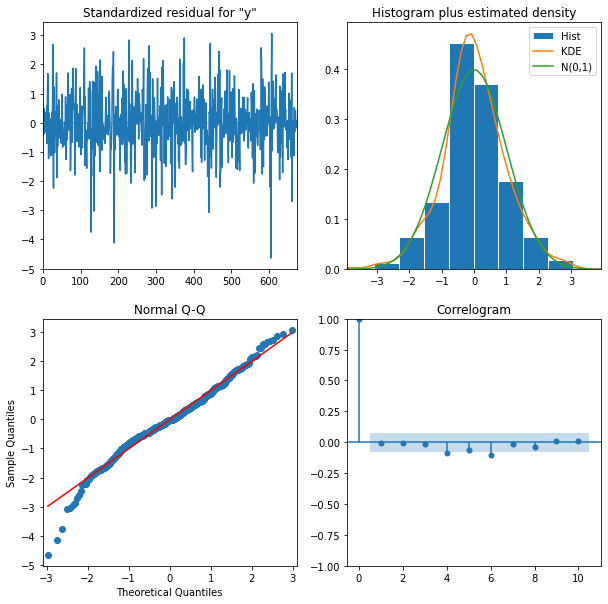

In [44]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm

# predict point forecasts
for uid in df_tr_norm['unique_id'].unique():
    y_tr = df_tr_norm.loc[df_tr_norm['unique_id'] == uid, 'y']
    res = ARIMA(y_tr, order=([1,24],0,1)).fit()
    res.plot_diagnostics(figsize=(10, 10))
    y_hat = res.forecast(48)*stds[uid] +means[uid] 
    df_hat.loc[df_hat['unique_id'] == uid, 'y_test'] = y_hat.values

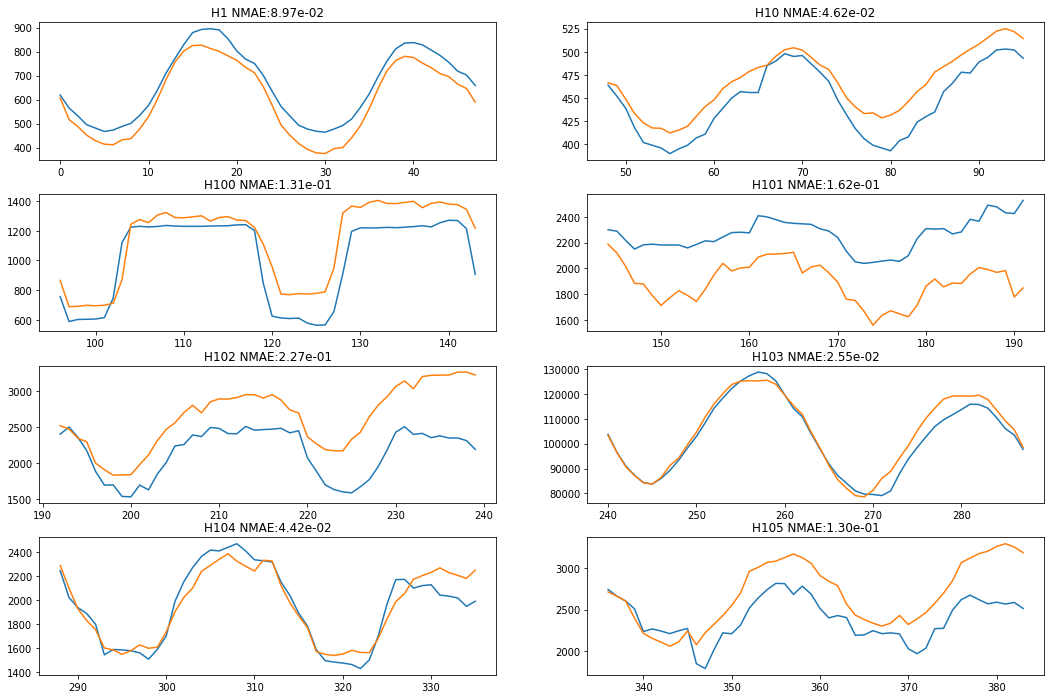

In [45]:
# plot results
fig, ax = plt.subplots(4, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.25)
for uid, a in zip(df_tr['unique_id'].unique(), ax.ravel()):
    y_te = df_te.loc[df_hat['unique_id'] == uid, 'y_test']
    y_hat = df_hat.loc[df_hat['unique_id'] == uid, 'y_test']
    y_te.plot(ax=a)
    y_hat.plot(ax=a)
    a.set_title('{} NMAE:{:0.2e}'.format(uid,nmae(y_te.values.ravel(), y_hat.values.ravel())))

In [ ]:
# predict point forecasts
for uid in df_tr_norm['unique_id'].unique():
    y_tr = df_tr_norm.loc[df_tr_norm['unique_id'] == uid, 'y']
    res = ARIMA(y_tr, order=(2,2,1), seasonal_order=(1, 1, 0, 24)).fit()
    res.plot_diagnostics(figsize=(10, 10))
    y_hat = res.forecast(48)*stds[uid] +means[uid] 
    df_hat.loc[df_hat['unique_id'] == uid, 'y_test'] = y_hat.values

# plot results
fig, ax = plt.subplots(4, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.25)
for uid, a in zip(df_tr['unique_id'].unique(), ax.ravel()):
    y_te = df_te.loc[df_hat['unique_id'] == uid, 'y_test']
    y_hat = df_hat.loc[df_hat['unique_id'] == uid, 'y_test']
    y_te.plot(ax=a)
    y_hat.plot(ax=a)
    a.set_title('{} NMAE:{:0.2e}'.format(uid,nmae(y_te.values.ravel(), y_hat.values.ravel())))

## AUTO arima
The following code uses the package `statsforecasts`, which was addressed in the `dart` library.

In [13]:
%%capture 
! pip install statsforecast

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

sf = StatsForecast(
    models = [AutoARIMA(season_length = 24, approximation=True)],
    freq = 'H', n_jobs=-1
)
sf.fit(df_tr_norm)
y_hat = sf.predict(48, level = [80, 90])

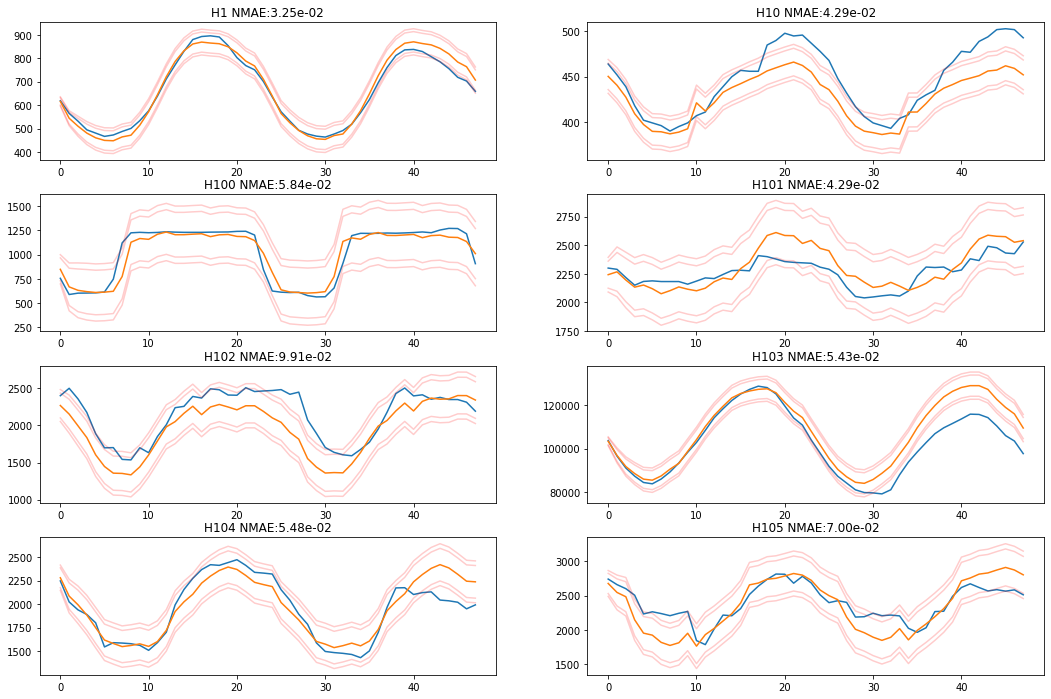

In [28]:
# plot results
q_names = ['lo-90','lo-80','hi-90','hi-80']
fig, ax = plt.subplots(4, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.25)
for uid, a in zip(df_tr['unique_id'].unique(), ax.ravel()):
    y_te = df_te.loc[df_hat['unique_id'] == uid, 'y_test'].reset_index(drop=True)
    y_hat_s = y_hat.loc[y_hat.index == uid, 'AutoARIMA'].reset_index(drop=True)*stds[uid] + means[uid] 
    y_te.plot(ax=a)
    y_hat_s.plot(ax=a)
    [a.plot(y_hat.loc[y_hat.index == uid, '{}-{}'.format('AutoARIMA', q_str)].reset_index(drop=True)*stds[uid] + means[uid], color='red', alpha=0.2) for q_str in q_names]
    a.set_title('{} NMAE:{:0.2e}'.format(uid,nmae(y_te.values.ravel(), y_hat_s.values.ravel())))

In [42]:
sf.fitted_[0][0].model_['coef']

{'ar1': 1.1770679971423499,
 'ar2': -0.3593594192486791,
 'ma1': 0.09145075521453852,
 'ma2': 0.29428692771379034,
 'sar1': -0.11536962133636884,
 'sma1': -0.7131735979055591}

# Probabilistic forecasts with neural models and quantile loss
In the following we will train recursive neural models using the `NeuralForecast` library, using the quantile loss function: 

$$\rho(y,\hat{q},\tau) = (\tau-1) \sum_{y_i<\hat{q}
}\left(y_i-\hat{q}\right)+\tau \sum_{y_i \geq \hat{q}}\left(y_i-\hat{q}\right)$$


We will fit:
* a naive Long Short Term Memory Network [(LSTM)](https://arxiv.org/abs/2201.12886)
* the Neural Hierarchical Interpolation [(NHITS)](https://arxiv.org/abs/2201.12886) model 


In [ ]:
%%capture
!pip install git+https://github.com/Nixtla/neuralforecast.git@main

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.models import LSTM, DilatedRNN, NHITS

In [ ]:
horizon = 48
levels = [80, 90]
models = [LSTM(input_size=-1, h=horizon,
               loss=MQLoss(level=levels), max_epochs=300),
          NHITS(input_size=7*horizon, h=horizon,
                n_freq_downsample=[24, 12, 1],
                loss=MQLoss(level=levels), max_epochs=200),]
fcst = NeuralForecast(models=models, freq='H')

INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [ ]:
%%capture
fcst.fit(df=df_tr)

In [ ]:
forecasts = fcst.predict()
forecasts = forecasts.reset_index()
forecasts.head()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,LSTM-median,LSTM-lo-90,LSTM-lo-80,LSTM-hi-80,LSTM-hi-90,NHITS-median,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90
0,H1,701,641.103638,499.322021,533.042114,727.454834,769.625061,649.356445,516.789307,576.559509,723.810547,729.386963
1,H1,702,578.741638,448.665161,472.153198,684.580505,722.430786,586.928528,479.963348,522.909485,653.856812,659.233643
2,H1,703,527.009583,389.631317,422.053009,643.878235,681.090515,513.998535,427.917877,469.042358,601.579895,614.186951
3,H1,704,488.915100,345.985840,372.479523,610.594788,645.455994,461.343445,381.887878,430.622833,546.481995,569.867615
4,H1,705,462.556519,311.708649,343.567719,576.882751,613.076294,434.297119,365.713165,397.333618,503.222290,519.749268


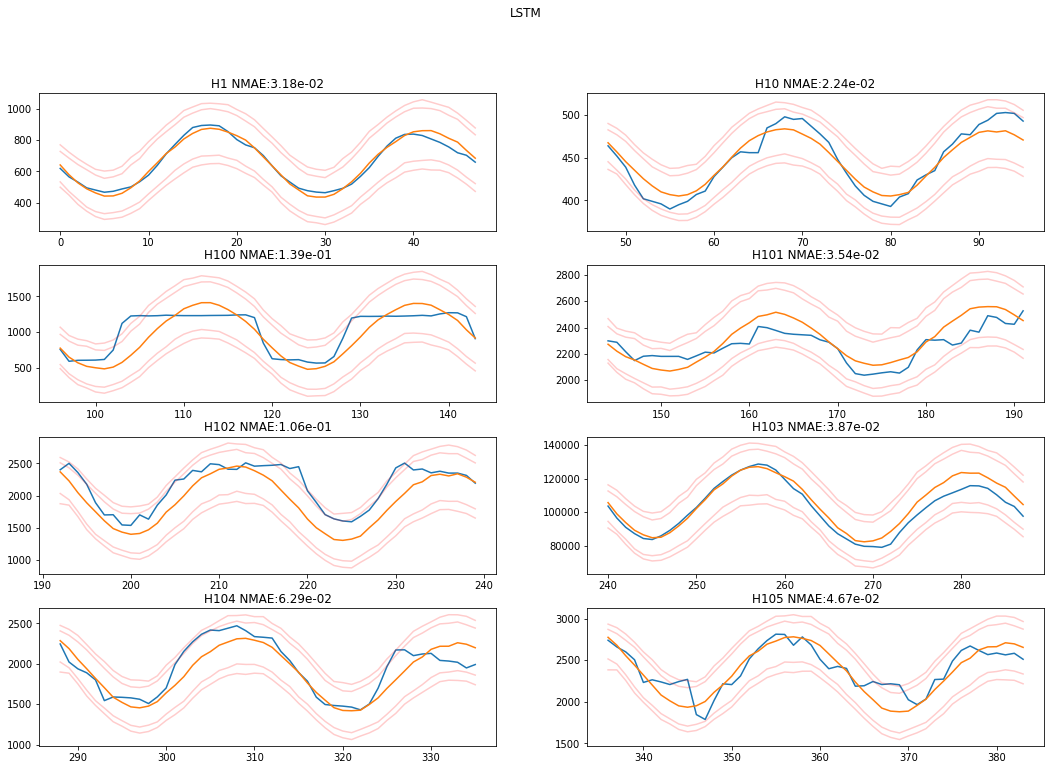

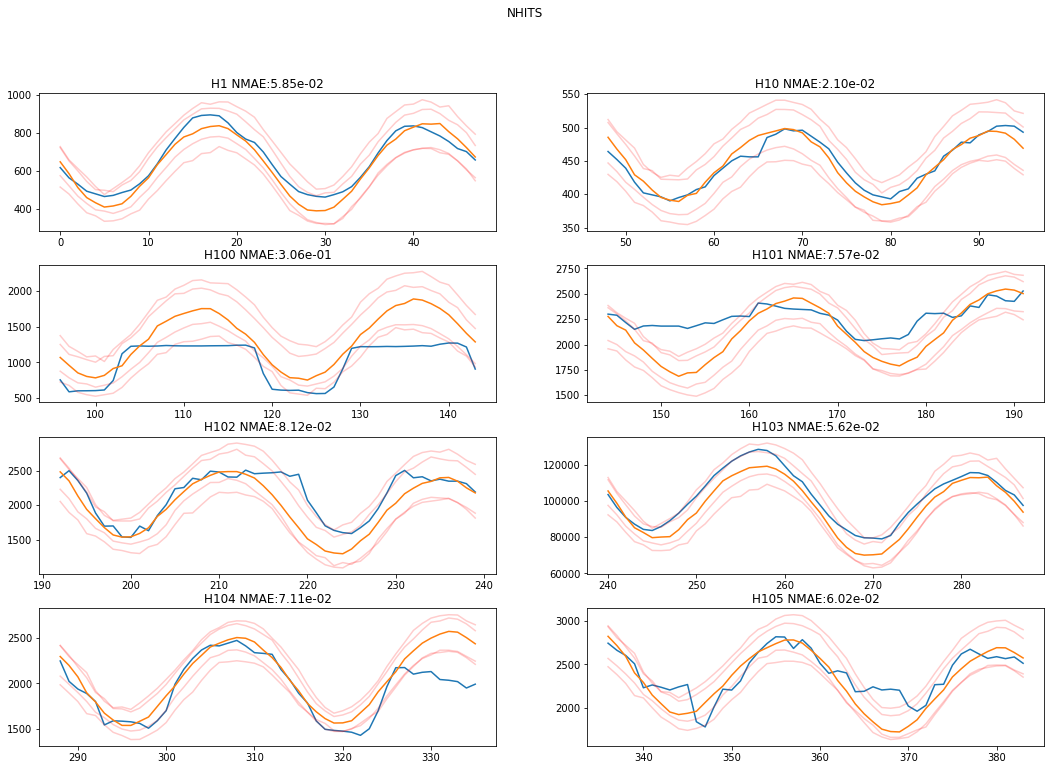

In [ ]:
def plot_results(model):
  q_names = ['lo-90','lo-80','hi-90','hi-80']
  fig, ax = plt.subplots(4, 2, figsize=(18, 12))
  plt.subplots_adjust(hspace=0.25)
  for uid, a in zip(df_tr['unique_id'].unique(), ax.ravel()):
      y_te = df_te.loc[df_te['unique_id'] == uid, 'y_test']
      y_hat = forecasts.loc[forecasts['unique_id'] == uid, '{}-median'.format(model)]
      y_te.plot(ax=a)
      [a.plot(forecasts.loc[forecasts['unique_id'] == uid, '{}-{}'.format(model, q_str)], color='red', alpha=0.2) for q_str in q_names]
      y_hat.plot(ax=a)
      a.set_title('{} NMAE:{:0.2e}'.format(uid,nmae(y_te.values.ravel(), y_hat.values.ravel())))
  plt.suptitle(model)  

plot_results('LSTM')
plot_results('NHITS')